In [9]:
import sys
import yaml
import time
from pathlib import Path

import pandas as pd
import connectorx as cx
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# custom
sys.path.append(str(Path('../..').resolve()))
from src.pipeline.clients import get_db_client
from src.utils.db_operator import SQLQueryOperator

In [2]:
sql = SQLQueryOperator(config_path='../../source_config.yaml')

### Timespan data collection

In [3]:
dates_min_max = sql("""select max(time), min(time) from prod.files_image""")
dates_min_max

Retrieved 1 datapoints in 0.307 seconds


,max,min
0,2022-09-30 08:35:10,2021-06-20 14:48:58


In [4]:
dates_min_max['max'].iloc[0] - dates_min_max['min'].iloc[0]

Timedelta('466 days 17:46:12')

### Image Recordings per day

In [5]:
data = sql(
    """
    SELECT date_trunc('day', time) as date_time, count(object_name) from prod.files_image
    GROUP by date_time
    ORDER BY date_time
    """)
data = data.set_index('date_time')
data.head(2)

Retrieved 195 datapoints in 1.528 seconds


,count
date_time,
2021-06-19 22:00:00,2
2021-06-20 22:00:00,11685


In [61]:
paired_palette = {"colors":[{"value":"rgba(166, 206, 227, 1)"},{"value":"rgba(31, 120, 180, 1)"},
                            {"value":"rgba(178, 223, 138, 1)"},{"value":"rgba(51, 160, 44, 1)"},
                            {"value":"rgba(251, 154, 153, 1)"},{"value":"rgba(227, 26, 28, 1)"},
                            {"value":"rgba(253, 191, 111, 1)"},{"value":"rgba(255, 127, 0, 1)"},
                            {"value":"rgba(202, 178, 214, 1)"},{"value":"rgba(106, 61, 154, 1)"},
                            {"value":"rgba(255, 255, 153, 1)"},{"value":"rgba(177, 89, 40, 1)"}]}
paired_palette = [c['value'] for c in paired_palette['colors']]

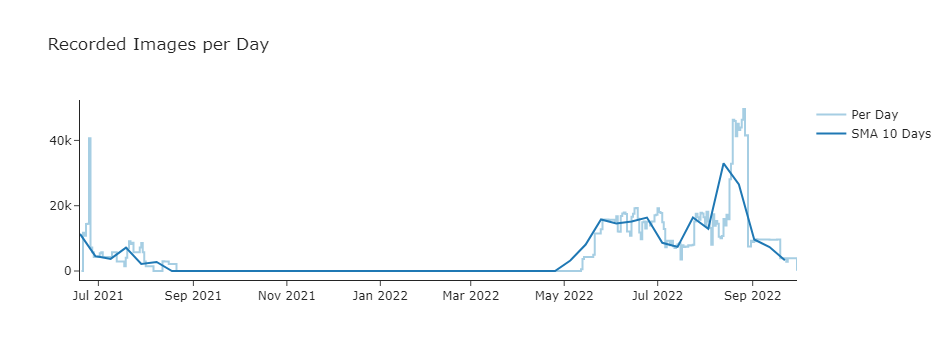

In [63]:
palette = iter(paired_palette)
SMA = 10

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['count'],
    name='Per Day',
    line_shape='hv',
    line_color=next(palette)
))

tmp = data.resample(f'{SMA}D').mean().fillna(0)

fig.add_trace(go.Scatter(
    x=tmp.index, 
    y=tmp['count'],
    name=f'SMA {SMA} Days',
    line_color=next(palette)
))
fig.update_layout(
    title='Recorded Images per Day', 
    template='simple_white'
)

### Active Nodes per day

In [64]:
query_string = """
    SELECT day_time, count(day_time)
    FROM (
        SELECT
            date_trunc('day', prod.files_image.time) as day_time,
            prod.deployments.node_id
        FROM prod.files_image
        LEFT JOIN prod.deployments
        ON prod.files_image.deployment_id = prod.deployments.deployment_id
        GROUP BY day_time, node_id
    ) AS tmp
    GROUP BY day_time
"""

In [65]:
data = sql(query_string)

Retrieved 195 datapoints in 3.307 seconds


In [70]:
data = data.sort_values('day_time')
data = data.set_index('day_time')
data.head(5)

,count
day_time,
2021-06-19 22:00:00,1
2021-06-20 22:00:00,8
2021-06-21 22:00:00,6
2021-06-22 22:00:00,5
2021-06-23 22:00:00,5


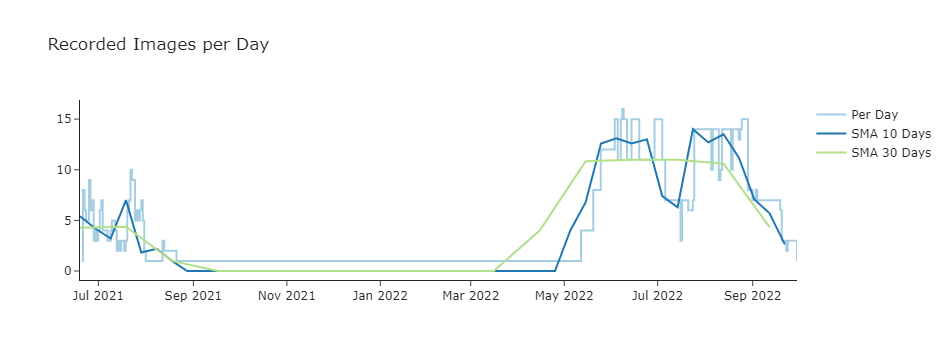

In [77]:
palette = iter(paired_palette)
SMA = 10
SMA2 = 30

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['count'],
    name='Per Day',
    line_shape='hv',
    mode='lines',
    line_color=next(palette)
))

tmp = data.resample(f'{SMA}D').mean().fillna(0)
fig.add_trace(go.Scatter(
    x=tmp.index, 
    y=tmp['count'],
    name=f'SMA {SMA} Days',
    mode='lines',
    line_color=next(palette)
))

tmp = data.resample(f'{SMA2}D').mean().fillna(0)
fig.add_trace(go.Scatter(
    x=tmp.index, 
    y=tmp['count'],
    name=f'SMA {SMA2} Days',
    mode='lines',
    line_color=next(palette)
))


fig.update_layout(
    title='Recorded Images per Day', 
    template='simple_white'
)

### Pollinators measured per Day?

In [87]:
query = """
SELECT 
    date_trunc('day', prod.files_image.time) as day_time,
    COUNT(prod.pollinators.pollinator_id)
FROM prod.files_image
LEFT JOIN prod.image_results ON prod.files_image.file_id = prod.image_results.file_id
LEFT JOIN prod.pollinators ON prod.image_results.result_id = prod.pollinators.result_id
GROUP BY day_time
ORDER BY day_time
"""
measured_pollinators = sql(query)

Retrieved 195 datapoints in 4.272 seconds


In [90]:
measured_pollinators.head(2)

,day_time,count
0,2021-06-19 22:00:00,0
1,2021-06-20 22:00:00,1491


In [91]:
query = """
    SELECT day_time, count(day_time)
    FROM (
        SELECT
            date_trunc('day', prod.files_image.time) as day_time,
            prod.deployments.node_id
        FROM prod.files_image
        LEFT JOIN prod.deployments
        ON prod.files_image.deployment_id = prod.deployments.deployment_id
        GROUP BY day_time, node_id
    ) AS tmp
    GROUP BY day_time
    ORDER BY day_time
"""
active_nodes = sql(query)

Retrieved 195 datapoints in 2.485 seconds


In [92]:
active_nodes.head(2)

,day_time,count
0,2021-06-19 22:00:00,1
1,2021-06-20 22:00:00,8


In [83]:
data = sql("""
    SELECT * 
    FROM (
    SELECT 
        date_trunc('day', files_image.time) as day,
        pollinators.class, count(pollinators.class)
        from prod.files_image
        LEFT JOIN prod.image_results
        ON files_image.file_id = image_results.file_id
        LEFT JOIN prod.pollinators
        ON image_results.result_id = pollinators.result_id
        GROUP BY day, pollinators.class
        ORDER BY day
    ) AS tmp
    WHERE tmp.class IS NOT NULL
""")

Retrieved 742 datapoints in 0.975 seconds


In [84]:
data.head(10)

,day,class,count
0,2021-06-20 22:00:00,fliege,824
1,2021-06-20 22:00:00,honigbiene,6
2,2021-06-20 22:00:00,schwebfliege,29
3,2021-06-20 22:00:00,wildbiene,632
4,2021-06-21 22:00:00,fliege,240
5,2021-06-21 22:00:00,honigbiene,7
6,2021-06-21 22:00:00,schwebfliege,12
7,2021-06-21 22:00:00,wildbiene,364
8,2021-06-22 22:00:00,fliege,1039
9,2021-06-22 22:00:00,honigbiene,177


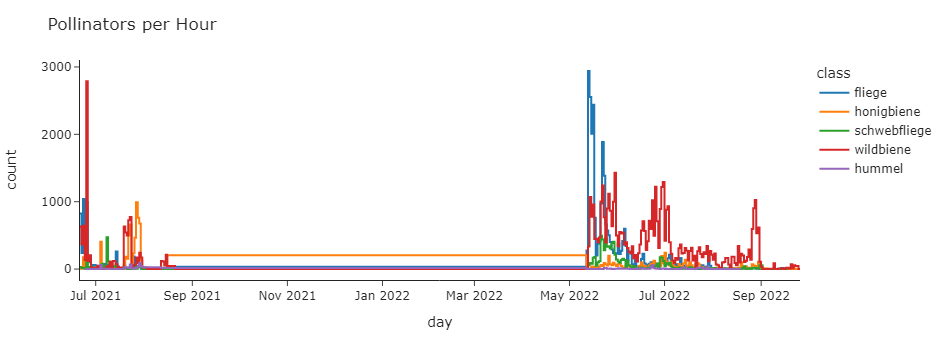

In [86]:
fig = px.line(data_frame=data, x='day', y='count', color='class', 
              line_shape='hv', template='simple_white')
fig.update_layout(title='Pollinators per Hour')
fig.show()

### Pollinators distributed over Weeks and Days (Heatmap)

In [53]:
res.sort_values('time')

,time,class,count
303976,2021-06-20 14:00:00,None,0
589932,2021-06-20 16:00:00,None,0
321811,2021-06-21 08:00:00,None,0
761967,2021-06-21 08:00:00,None,0
300510,2021-06-21 08:00:00,None,0
...,...,...,...
87415,2022-09-30 08:00:00,None,0
587953,2022-09-30 08:00:00,None,0
30107,2022-09-30 08:00:00,None,0
560866,2022-09-30 08:00:00,None,0


In [48]:
res = res.sort_values(by='time').reset_index(drop=True)
res = res.dropna(axis=0)
res.head(20)

,time,class,count
0,2021-06-21 08:00:00,fliege,1
1,2021-06-21 08:00:00,wildbiene,1
2,2021-06-21 08:00:00,wildbiene,1
3,2021-06-21 08:00:00,fliege,1
4,2021-06-21 08:00:00,fliege,1
5,2021-06-21 08:00:00,wildbiene,1
6,2021-06-21 08:00:00,wildbiene,1
7,2021-06-21 08:00:00,fliege,1
8,2021-06-21 08:00:00,wildbiene,1
9,2021-06-21 08:00:00,wildbiene,1


In [47]:
fig = px.line(data_frame=res, x='hour', y='count', color='class', line_shape='hv', template='simple_white', )
fig.update_layout(title='Pollinators per Hour')
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['time', 'class', 'count'] but received: hour